In [1]:
import arviz as az
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import seaborn.objects as so
import numpy as np
import pandas as pd
import polars as pl
import pymc as pm
import pytensor as pt
import pybaseball 
#from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
#from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
#import xgboost as xgb

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
pt.config.exception_verbosity = 'high'

RANDOM_SEED = 504

print(f"Running on PyMC v{pm.__version__}")


Running on PyMC v5.20.0


In [2]:
from retrieve_sql_module import get_description_data
events_data_2024 = get_description_data("2024")

In [3]:
events_data_2024

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,n_thruorder_pitcher,n_priorpa_thisgame_player_at_bat,pitcher_days_since_prev_game,batter_days_since_prev_game,pitcher_days_until_next_game,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle
0,KC,2024-10-30,77.5,-1.11,5.65,"Buehler, Walker",657077,621111,strikeout,swinging_strike_blocked,...,1,4,2.0,1.0,NaN,NaN,5.23,-1.08,1.08,53.2
1,KC,2024-10-30,77.4,-1.23,5.78,"Buehler, Walker",669224,621111,strikeout,swinging_strike,...,1,4,2.0,1.0,NaN,NaN,5.20,-1.08,1.08,50.0
2,KC,2024-10-30,77.6,-1.08,5.75,"Buehler, Walker",683011,621111,field_out,hit_into_play,...,1,4,2.0,1.0,NaN,NaN,5.33,-1.08,-1.08,53.9
3,ST,2024-10-30,79.4,-1.48,5.81,"Leiter Jr., Mark",669257,643410,field_out,hit_into_play,...,1,4,1.0,1.0,NaN,NaN,4.20,-0.91,-0.91,45.7
4,CU,2024-10-30,75.5,-1.14,6.05,"Leiter Jr., Mark",669242,643410,strikeout,swinging_strike,...,1,4,1.0,1.0,NaN,NaN,5.52,-0.60,0.60,54.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193076,FF,2024-03-24,96.1,-2.18,5.48,"Vodnik, Victor",621545,680767,sac_bunt,hit_into_play,...,1,0,NaN,NaN,NaN,NaN,1.12,0.46,0.46,NaN
193077,None,2024-03-22,NaN,NaN,NaN,"Jiménez, Dany",669352,666204,sac_bunt,hit_into_play,...,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193078,None,2024-03-22,NaN,NaN,NaN,"Cannon, Jonathan",501303,686563,sac_bunt,hit_into_play,...,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193079,None,2024-03-20,NaN,NaN,NaN,"Singer, Brady",605346,663903,sac_bunt,hit_into_play,...,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
unique_batters = events_data_2024["batter"].unique()
batter_id_map = {b:i for i, b in enumerate(unique_batters)}

In [5]:
woba_values = events_data_2024["woba_value"].values
batter_ids = events_data_2024["batter"].map(batter_id_map).values

In [6]:
coords = {
    "batter": unique_batters
}

In [36]:
coords

{'batter': array([657077, 669224, 683011, ..., 703607, 689959, 624414])}

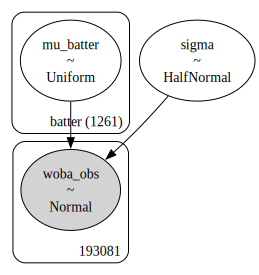

In [7]:
with pm.Model(coords=coords) as uninformative_prior_model:
    mu_batter = pm.Uniform("mu_batter", lower = 0, upper = 2, dims = "batter")
    sigma = pm.HalfNormal("sigma", sigma = 0.2)

    woba_obs = pm.Normal("woba_obs", mu = mu_batter[batter_ids], sigma = sigma, observed = events_data_2024["woba_value"].values)
pm.model_to_graphviz(uninformative_prior_model)

In [13]:
with uninformative_prior_model:
    uninformed_prior_trace = pm.sample_prior_predictive(1000)

Sampling: [mu_batter, sigma, woba_obs]


In [10]:
uninformed_prior_trace

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

<Axes: ylabel='Density'>

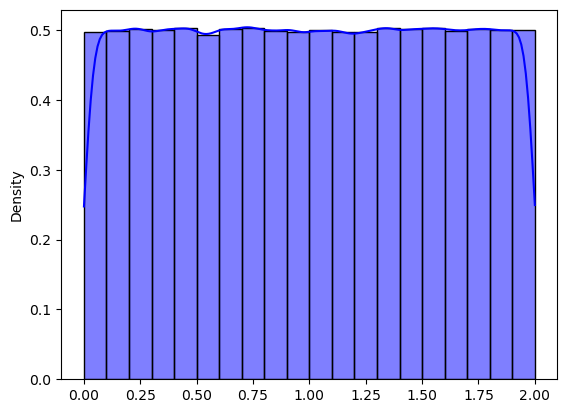

In [14]:
mu_samples = uninformed_prior_trace.prior["mu_batter"].values.flatten()
sns.histplot(mu_samples, bins = 20, kde = True, stat="density", color="blue", edgecolor="black")

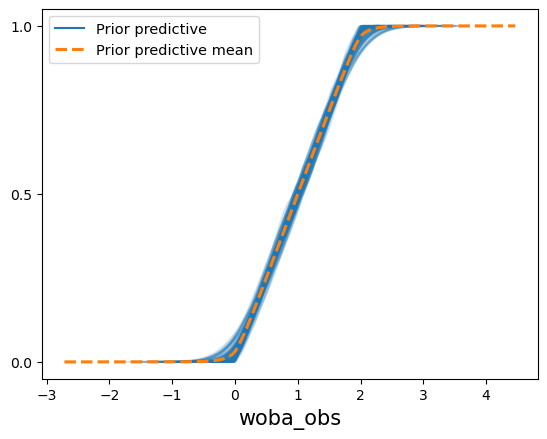

In [15]:
az.plot_ppc(uninformed_prior_trace, group='prior', kind='cumulative', num_pp_samples=100);


In [ ]:
with pm.Model(coords=coords) as informative_prior_model:
    mu_batter = pm.Uniform("mu_batter", lower = 0, upper = 2, dims = "batter")
    sigma = pm.HalfNormal("sigma", sigma = 0.2)

    woba_obs = pm.Normal("woba_obs", mu = mu_batter[batter_ids], sigma = sigma, observed = events_data_2024["woba_value"].values)
pm.model_to_graphviz(uninformative_prior_model)